In [1]:
import time
import operator
import random
import pandas as pd
import numpy as np
from scipy.stats import norm
import spotipy
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from collections import Counter
from ast import literal_eval
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.linalg import norm
from sklearn import tree

%matplotlib inline

#  Request Authorization

Use client_credentials_manager for unauthorized requests (getting user playlists, getting song features, etc.) and util.prompt_for_token for authorized requests (top songs of a user). 

In [53]:
client_credentials_manager = (SpotifyClientCredentials(client_id='944c05ffa8d2479aa6bc25e0b522b8db', 
                                                       client_secret='55848e78225c4b8798d306fc17324719'))
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)                                                   

In [100]:
username = 'sgheinze'
client_id = '944c05ffa8d2479aa6bc25e0b522b8db'
client_secret = '55848e78225c4b8798d306fc17324719'
scope = 'user-top-read'
redirect_uri = 'http://localhost/'
token = util.prompt_for_user_token(username=username, scope=scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

#  Functions for data scraping

In [2]:
############## Functions used in reading playlist and getting song data ##############

# Get tracks on playlist
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

# Get track name
def get_track_name(index, tracks):
    return tracks[index]['track']['name']

# Get artists names
def get_artist_info(index, tracks):
    artists = []
    for artist in range(len(tracks[index]['track']['artists'])):
        artists.append(tracks[index]['track']['artists'][artist]['name'])
    return artists

# Get popularity of track
def get_track_popularity(index, tracks):
    return tracks[index]['track']['popularity']

# Get release year of track
def get_release_date(index, tracks):
    return int(tracks[index]['track']['album']['release_date'].split('-')[0])

# Get URI of track
def get_track_uri(index, tracks):
    return tracks[index]['track']['uri']

# Get genre of artist
def get_artist_genres(artists):
    if len(artists) > 1:
        artist_info = sp.search(q='artist:' + artists[0], type='artist')
    else:
        artist_info = sp.search(q='artist:' + artists, type='artist')
    genres = artist_info['artists']['items'][0]['genres']
    return genres

# Compile track name artist name, popularity, track uri, and genre information
def get_track_info(index, tracks):
    track_info = {}
    track_info['name'] = get_track_name(index, tracks)
    track_info['artists'] = get_artist_info(index, tracks)
    track_info['popularity'] = get_track_popularity(index, tracks)
    track_info['track_uri'] = get_track_uri(index, tracks)
    track_info['artist_genre'] = get_artist_genres(track_info['artists'][0])
    track_info['release_date'] = get_release_date(index, tracks)
    
    return track_info

# Get audio features of track
def get_audio_features(track_uri):
    audio_results = sp.audio_features(track_uri)[0]
    
    audio_features = {}
    audio_features['acousticness'] = audio_results['acousticness']
    audio_features['danceability'] = audio_results['danceability']
    audio_features['duration'] = audio_results['duration_ms']
    audio_features['energy'] = audio_results['energy']
    audio_features['instrumentalness'] = audio_results['instrumentalness']
    audio_features['key'] = audio_results['key']
    audio_features['liveness'] = audio_results['liveness']
    audio_features['loudness'] = audio_results['loudness']
    audio_features['mode'] = audio_results['mode']
    audio_features['speechiness'] = audio_results['speechiness']
    audio_features['tempo'] = audio_results['tempo']
    audio_features['valence'] = audio_results['valence']

    return audio_features

# Analyze playlist: performs all above functions and returns data in a dictionary song_data
def analyze_playlist(playlist_uri):
    
    song_data = []
    
    username = playlist_uri.split(':')[2]
    playlist_id = playlist_uri.split(':')[4]
    tracks = get_playlist_tracks(username, playlist_id)
    
    for track_index in range(len(tracks)):
        track_info = get_track_info(track_index, tracks)
        audio_features = get_audio_features(track_info['track_uri'])
        song_data.append({**track_info, **audio_features})
        time.sleep(2)
        
    return song_data

# Load playlist
def load_data(file):
    df = pd.read_csv(file, index_col = 0)
    #duration = df['duration'].copy() / 1000
    #popularity = df['popularity'].copy() / 100
    #df['duration'] = duration
    #df['popularity'] = popularity
    means_and_stds = get_audio_feature_means_and_stds(df)
    return df, means_and_stds

############## Functions used in analyzing song data ##############

# Get the means and standard deviations of audio features in dataframe containing song_data
def get_audio_feature_means_and_stds(playlist_df):
    features = (['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'liveness',
                'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'popularity'])
    means = []
    stds = []

    for feature in features:
        means.append(playlist_df[feature].mean())
        stds.append(playlist_df[feature].std())
    
    audio_features_df = pd.DataFrame([features, means, stds]).transpose().rename(columns={0: 'feature', 1: 'mean', 2: 'std'})
    return audio_features_df

# Normalizes all features to be within 0-1. Drops duration and mode.
def normalize_features(audio_features_df, name=None):
    audio_features_df_edit = audio_features_df.copy()
    audio_features_df_edit.drop([2], axis=0, inplace=True) # Drop duration
    audio_features_df_edit.drop([7], axis=0, inplace=True) # Drop mode
    #audio_features_df_edit.drop([6], axis=0, inplace=True) # Drop loudness
    audio_features_df_edit.drop([9], axis=0, inplace=True) # Drop tempo
    audio_features_df_edit.loc[6, 'mean'] /= -60 # Normalize loudness
    audio_features_df_edit.loc[6, 'std'] /= -60 # Normalize loudness
    #audio_features_df_edit.loc[9, 'mean'] = 1/60 * (audio_features_df_edit.loc[9, 'mean'] - 80) # Normalize tempo
    #audio_features_df_edit.loc[9, 'std'] = 1/60 * (audio_features_df_edit.loc[9, 'std']) # Normalize tempo
    if name != None:
        audio_features_df_edit['name'] = name
    
    return audio_features_df_edit

# Count genres of artists in playlist, normalized by number of songs, in percent
def genre_counter(playlist):

    genre_list = []
    count = 0

    for index, row in playlist.iterrows():
        artist = literal_eval(row['artists'])[0]
        count += 1
        for genre in literal_eval(row['artist_genre']):
            genre_list.append(genre)
    
    temp = Counter(genre_list)
    genres = {}
    
    for key, value in temp.items():
        genres[str(key)] = value / count * 100
        
    return genres

#  Get data for Stefan and Kelsey's playlists

Here we scrape each playlist for the contained songs and then scrape each song for the audio features. We store the data in a pandas dataframe and save for later use.

In [104]:
# Scrape data for Stefan's music

stefan_song_data = analyze_playlist('spotify:user:sgheinze:playlist:7536GdRaLQAHe87wi0ax1J')
stefan_playlist_df = pd.DataFrame(stefan_song_data)
stefan_means_and_stds_df = get_audio_feature_means_and_stds(stefan_playlist_df)

# Scrape data for Kelsey's music

kelsey_song_data = analyze_playlist('spotify:user:1212809566:playlist:0zVjRhqWbmFPmDYjmUHUJz')
kelsey_playlist_df = pd.DataFrame(kelsey_song_data)
kelsey_means_and_stds_df = get_audio_feature_means_and_stds(kelsey_playlist_df)

# Save music for later use.

stefan_playlist_df.to_csv('stefan_music.csv')
kelsey_playlist_df.to_csv('kelsey_music.csv')

# Show structure of dataframe

stefan_playlist_df.head()

acousticness                                       artist_genre  \
0       0.00346  ['dance pop', 'pop', 'post-teen pop', 'tropica...   
1       0.00136  ['dance pop', 'pop', 'post-teen pop', 'tropica...   
2       0.00403  ['dance pop', 'pop', 'post-teen pop', 'tropica...   
3       0.03220           ['dwn trap', 'pop', 'rap', 'trap music']   
4       0.15800           ['dwn trap', 'pop', 'rap', 'trap music']   

           artists  danceability  duration  energy  instrumentalness  key  \
0       ['STRFKR']         0.605    180720   0.825          0.854000    1   
1       ['STRFKR']         0.480    157067   0.778          0.844000   10   
2       ['STRFKR']         0.488    271027   0.751          0.690000   10   
3  ['Arcade Fire']         0.315    239065   0.915          0.000006    6   
4  ['Arcade Fire']         0.508    191600   0.692          0.655000    6   

   liveness  loudness  mode                   name  popularity  speechiness  \
0    0.0531    -7.767     0                  Holly          37       0.0386   
1    0.3980    -8.900     1               Miss You          33       0.0304   
2    0.2390    -6.243     0    Isabella of Castile          46       0.0343   
3    0.6980    -4.548     0       You Already Know          36       0.1030   
4    0.1030    -4.918     1  City With No Children           6       0.0328   

     tempo                             track_uri  valence  
0  117.608  spotify:track:0XJyFdEV53XgpP90nEeab1    0.615  
1   99.887  spotify:track:7jGBayWeRx9L7dal30nirr    0.183  
2   82.991  spotify:track:4wj53ItvfETfYRs4zzmiPC    0.167  
3  177.148  spotify:track:0lijVPETlmWEPFzGXMjhDs    0.601  
4  128.201  spotify:track:31iXIwJlgBluoFdU095dXL    0.659

In [3]:
# Load music data

stefan_playlist_df, stefan_means_and_stds_df = load_data('stefan_music.csv')
kelsey_playlist_df, kelsey_means_and_stds_df = load_data('kelsey_music.csv')

# Data analysis for Stefan's music

We start by looking at the distributions for a couple of the key audio features for my playlist.

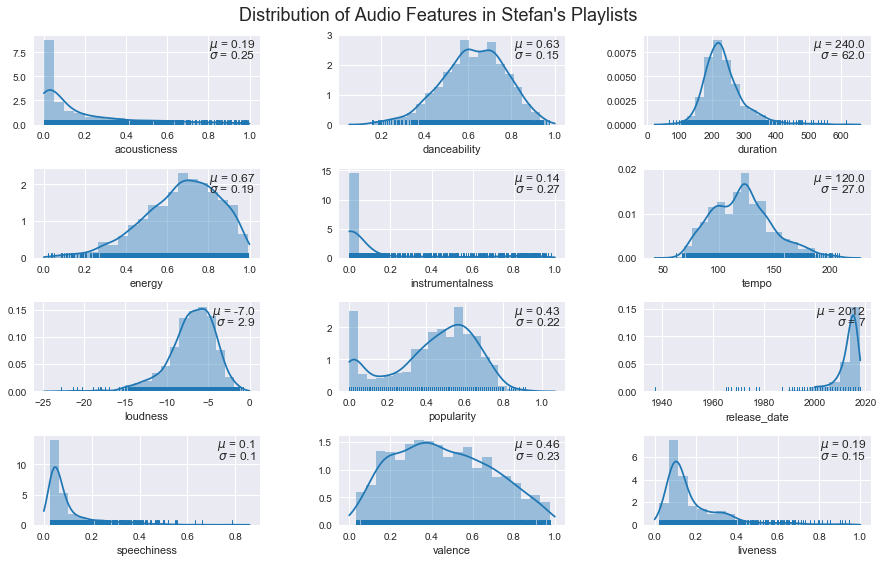

In [48]:
# Select relevant features
relevant_features = (['acousticness', 'danceability', 'duration', 
                      'energy', 'instrumentalness', 'tempo',
                     'loudness', 'popularity', 'release_date',
                     'speechiness', 'valence', 'liveness'])

# Define means for legend
means = stefan_means_and_stds_df.set_index('feature')['mean']
means['release_date'] = 2012
stds = stefan_means_and_stds_df.set_index('feature')['std']
stds['release_date'] = 7

# Plot data
sns.set()
sns.set_palette("tab10")
fig, axs = plt.subplots(4,3, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.35)
axs = axs.ravel()

bins=20
for i in range(len(axs)):
    mean = r'$\mu$ = ' + '%s' % float('%.2g' % means[relevant_features[i]])
    std = r'$\sigma$ = ' + '%s' % float('%.2g' % stds[relevant_features[i]])
    if relevant_features[i] == 'release_date':
        clip_range = (2000,2018)
        mean = r'$\mu$ = ' + '2012'
        std = r'$\sigma$ = ' + '7'
    elif relevant_features[i] == 'duration':
        clip_range = (0,500000)
    elif relevant_features[i] == 'tempo':
        clip_range = (0,300)
    elif relevant_features[i] == 'loudness':
        clip_range = (-60,0)
    elif relevant_features[i] == 'popularity':
        clip_range = (0,100)
    else: 
        clip_range = (0,1)
    sns.distplot(stefan_playlist_df[relevant_features[i]], bins=bins, kde=True, rug=True, color='C0', ax=axs[i], kde_kws={'clip': clip_range})
    axs[i].annotate(mean, 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top')
    axs[i].annotate(std, 
                    xy = (1,1),
                    xytext=(0.98, 0.855),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top') 
plt.suptitle("Distribution of Audio Features in Stefan's Playlists", fontsize=18, y=0.925)
plt.savefig('stefan_distribution.png', dpi=200, format='png', bbox_inches='tight')

Next we analyze correlations between these attributes

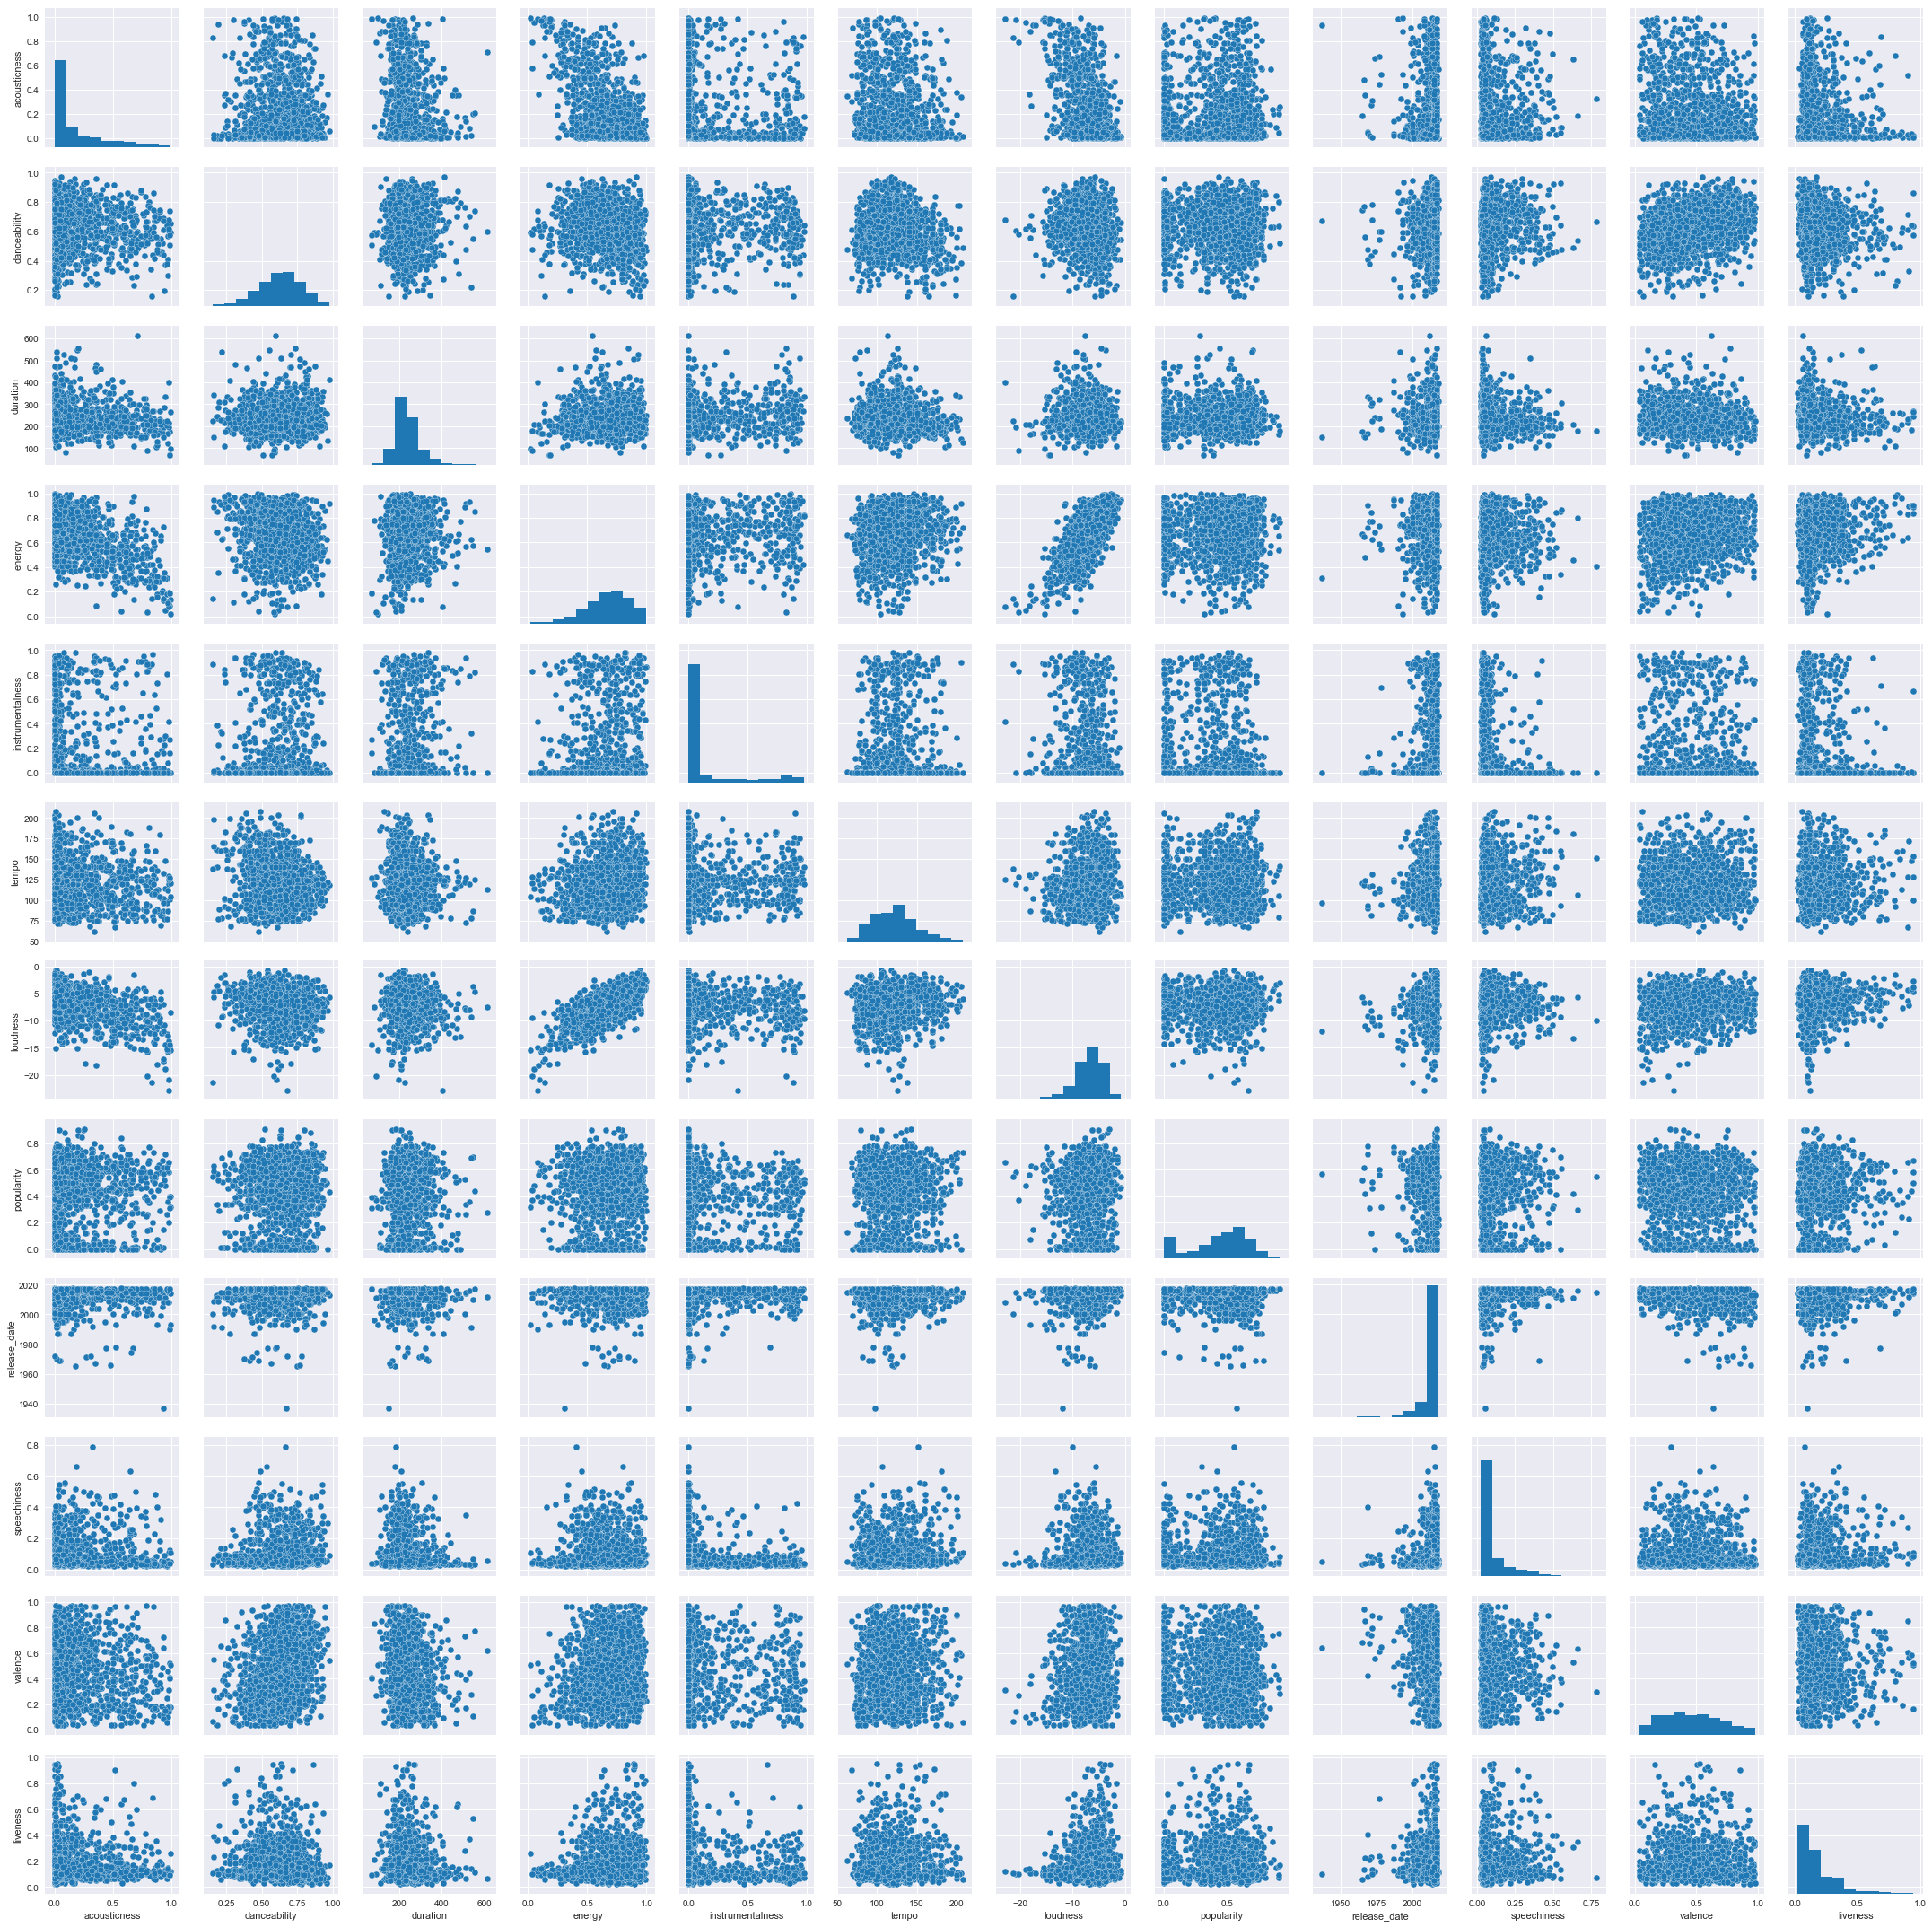

In [13]:
# Plot correlations for all relevant features.
sns.pairplot(stefan_playlist_df[relevant_features])
plt.savefig('stefan_feature_correlations.png', dpi=200, format='png')

In [145]:
# Calculate correlations and display any with r > 0.5
correlations = []
for index in range(len(relevant_features)):
    for index2 in range(index+1, len(relevant_features)):
        pc = pearsonr(stefan_playlist_df[relevant_features[index]], stefan_playlist_df[relevant_features[index2]])[0]
        correlations.append([index, index2, pc])
        
#correlations.sort(key=lambda x: abs(x[2]), reverse=True)
for pair in correlations:
    if abs(pair[2]) > 0.5:
        print(("The correlation between %s and %s is: %0.2f" % 
               (relevant_features[pair[0]], relevant_features[pair[1]], pair[2])))

The correlation between acousticness and energy is: -0.58
The correlation between energy and loudness is: 0.73


# Data analysis for Stefan and Kelsey's music

Let's compare the distribution of audio features in my playlist to my girlfriend's, Kelsey. From here on out the color blue refers to Stefan and the color orange refers to Kelsey.

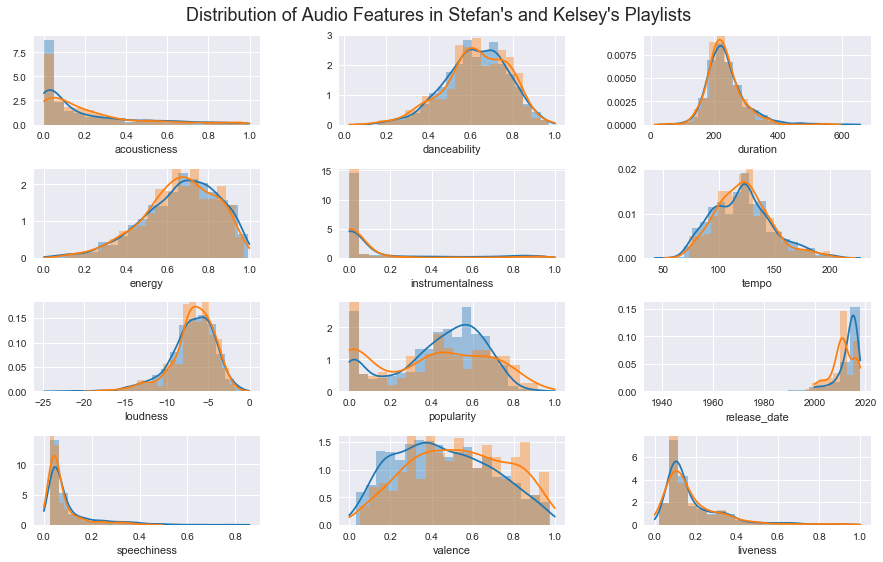

In [49]:
# Plot audio features distributions for both Kelsey and myself
sns.set()
sns.set_palette("tab10")
fig, axs = plt.subplots(4,3, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.35)
axs = axs.ravel()

bins=20
for i in range(len(axs)):
    if relevant_features[i] == 'release_date':
        clip_range = (2000,2018)
    elif relevant_features[i] == 'duration':
        clip_range = (0,500000)
    elif relevant_features[i] == 'tempo':
        clip_range = (0,300)
    elif relevant_features[i] == 'loudness':
        clip_range = (-60,0)
    elif relevant_features[i] == 'popularity':
        clip_range = (0,1)
    else: 
        clip_range = (0,1)
    sns.distplot(stefan_playlist_df[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C0', fit_kws={"color": 'C0'}, kde_kws={'clip': clip_range})
    sns.distplot(kelsey_playlist_df[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C1', fit_kws={"color": 'C1'}, kde_kws={'clip': clip_range})
plt.suptitle("Distribution of Audio Features in Stefan's and Kelsey's Playlists", fontsize=18, y=0.925)
plt.savefig('svsk_distributions.png', dpi=200, format='png', bbox_inches='tight')

Qualitatively, the distributions look very similar, but let's compute some quantitative metrics: the means and standard distributions. (Not shown are duration, tempo, and release_date because they are not easily normalizable)

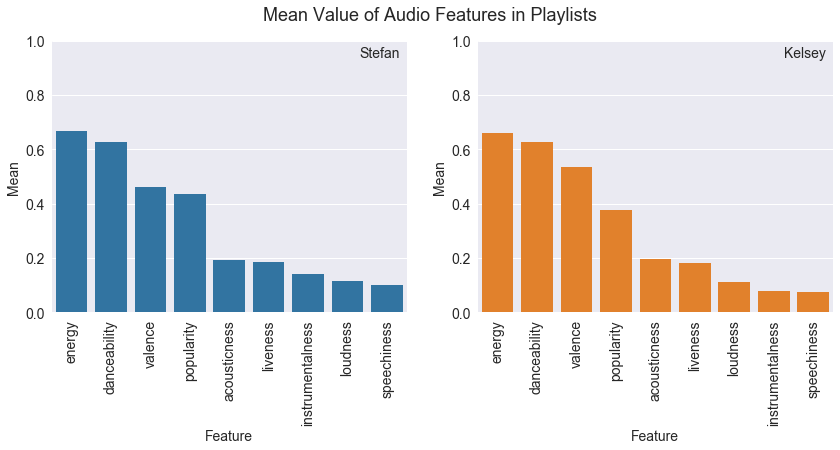

In [50]:
# Calculate audio feature means
stefan_audio_features = normalize_features(stefan_means_and_stds_df, 'Stefan')
stefan_audio_features.sort_values('mean', ascending=False, inplace=True)

kelsey_audio_features = normalize_features(kelsey_means_and_stds_df, 'Kelsey')
kelsey_audio_features.sort_values('mean', ascending=False, inplace=True)

# Plot audio feature means
sns.set()
sns.set_palette("tab10")
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='feature', y='mean', data=stefan_audio_features, color='C0')
ax1.set_ylabel('Mean', fontsize=14)
ax1.set_xlabel('Feature', fontsize=14)
ax1.set_ylim(0,1)
ax1.annotate('Stefan', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='feature', y='mean', data=kelsey_audio_features, color='C1')
ax2.set_ylabel('Mean', fontsize=14)
ax2.set_xlabel('Feature', fontsize=14)
ax2.set_ylim(0,1)
ax2.annotate('Kelsey', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.suptitle("Mean Value of Audio Features in Playlists", fontsize=18, y=0.975)
plt.savefig('svsk_means.png', dpi=200, format='png', bbox_inches='tight')

Calculate difference between means

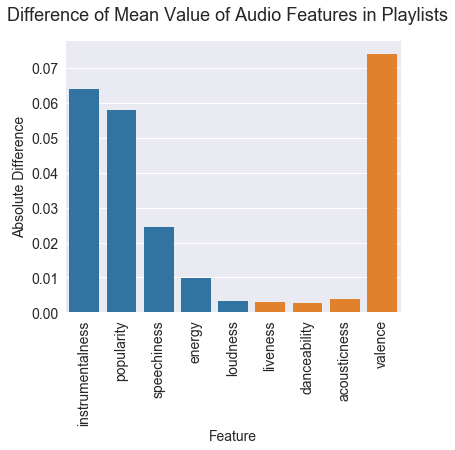

In [51]:
# Calculate differences between means and store in a pandas dataframe
audio_features = normalize_features(stefan_means_and_stds_df, 'Stefan')
audio_features = audio_features.append(normalize_features(kelsey_means_and_stds_df, 'Kelsey'), ignore_index=True)

audio_features_mi = audio_features.set_index(['feature', 'name'])
difference = pd.DataFrame(columns=['Feature', 'Difference', 'bigger'])
for feature in audio_features['feature'].unique():
    value = audio_features_mi.loc[(feature, 'Stefan'), 'mean'] - audio_features_mi.loc[(feature, 'Kelsey'), 'mean']
    if value > 0:
        bigger = 'Stefan'
    else:
        bigger = 'Kelsey'
    difference = difference.append({'Feature': feature, 'Difference': value, 'bigger': bigger}, ignore_index=True)

difference.sort_values('Difference', ascending=False, inplace=True)
difference['Absolute Difference'] = abs(difference['Difference'])

# Plot differences between means and color code each feature according to who has a larger mean.
sns.set()
sns.set_palette("tab10")
sc = ['C0']
kc = ['C1']
fig = plt.figure(figsize=(6,5))
ax = sns.barplot(x='Feature', y='Absolute Difference', data=difference, palette= sc*5 + kc*4)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Absolute Difference', fontsize=14)


plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.suptitle("Difference of Mean Value of Audio Features in Playlists", fontsize=18, y=0.975)
plt.savefig('svsk_means_diff.png', dpi=200, format='png', bbox_inches='tight')

Calculate standard deviations.

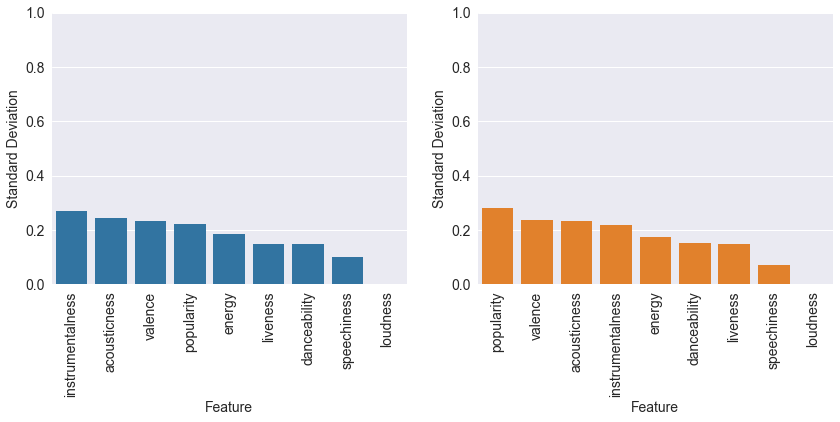

In [29]:
# Repeat above for standard deviations
stefan_audio_features = normalize_features(stefan_means_and_stds_df, 'Stefan')
stefan_sorted = stefan_audio_features.sort_values('std', ascending=False, inplace=True)

kelsey_audio_features = normalize_features(kelsey_means_and_stds_df, 'Kelsey')
kelsey_sorted = kelsey_audio_features.sort_values('std', ascending=False, inplace=True)

sns.set()
sns.set_palette("tab10")
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='feature', y='std', data=stefan_audio_features, color=sns.color_palette()[0])
ax1.set_ylabel('Standard Deviation', fontsize=14)
ax1.set_xlabel('Feature', fontsize=14)
ax1.set_ylim(0,1)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='feature', y='std', data=kelsey_audio_features, color=sns.color_palette()[1])
ax2.set_ylabel('Standard Deviation', fontsize=14)
ax2.set_xlabel('Feature', fontsize=14)
ax2.set_ylim(0,1)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.savefig('svsk_stds.png', dpi=200, format='png', bbox_inches='tight')

Calculate difference in standard deviations.

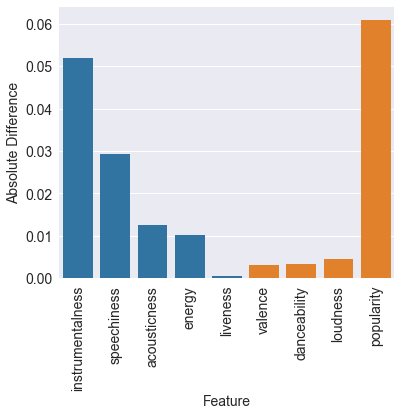

In [30]:
# Repeat above for standard deviations
audio_features = normalize_features(stefan_means_and_stds_df, 'Stefan')
audio_features = audio_features.append(normalize_features(kelsey_means_and_stds_df, 'Kelsey'), ignore_index=True)

audio_features_mi = audio_features.set_index(['feature', 'name'])
difference = pd.DataFrame(columns=['Feature', 'Difference', 'bigger'])
for feature in audio_features['feature'].unique():
    value = audio_features_mi.loc[(feature, 'Stefan'), 'std'] - audio_features_mi.loc[(feature, 'Kelsey'), 'std']
    if value > 0:
        bigger = 'Stefan'
    else:
        bigger = 'Kelsey'
    difference = difference.append({'Feature': feature, 'Difference': value, 'bigger': bigger}, ignore_index=True)

difference.sort_values('Difference', ascending=False, inplace=True)
difference['Absolute Difference'] = abs(difference['Difference'])

sns.set()
sns.set_palette("tab10")
sc = ['C0']
kc = ['C1']
fig = plt.figure(figsize=(6,5))
ax = sns.barplot(x='Feature', y='Absolute Difference', data=difference, palette= sc*5 + kc*4)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Absolute Difference', fontsize=14)

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.savefig('svsk_stds_diff.png', dpi=200, format='png', bbox_inches='tight')

# Calculating similarity

In [4]:
# functions to calculate overlap of histograms

def calculate_similarity(feature, df1, df2, r, bins):
    bin_prob_1, bin_loc_1 = np.histogram(df1[feature], range=r, bins=bins, normed=True)
    bin_prob_2, bin_loc_2 = np.histogram(df2[feature], range=r, bins=bins, normed=True)
    
    bin_width = bin_loc_1[2]-bin_loc_1[1]
    prob = 0
    for index in range(len(bin_loc_1)-1):
        prob += min(bin_width*bin_prob_1[index], bin_width*bin_prob_2[index])
    return prob

def calculate_playlist_similarity(relevant_features, df1, df2):
    prob = 0
    for feature in relevant_features:
        if feature == 'loudness':
            r = (-60,0)
            bins = 20
            prob += calculate_similarity(feature, df1, df2, r=r, bins=bins)
        elif feature == 'release_date':
            r = (1900,2020)
            bins = 120
            prob += calculate_similarity(feature, df1, df2, r=r, bins=bins)
        elif feature == 'tempo':
            r = (0, 200)
            bins = 40
            prob += calculate_similarity(feature, df1, df2, r=r, bins=bins)
        elif feature == 'duration':
            r = (0, 1000)
            bins = 200
            prob += calculate_similarity(feature, df1, df2, r=r, bins=bins)
        else:
            r = (0, 1)
            bins = 20
            prob += calculate_similarity(feature, df1, df2, r=r, bins=bins)
    prob /= len(relevant_features)
    return prob

In [7]:
# calculate similarity for playlists
relevant_features = (['acousticness', 'danceability', 'duration', 
                      'energy', 'instrumentalness', 'tempo',
                     'loudness', 'popularity', 'release_date',
                     'speechiness', 'valence', 'liveness'])

#s_vs_top2017 = calculate_playlist_similarity(relevant_features, stefan_playlist_df, top2017_df)
#k_vs_top2017 = calculate_playlist_similarity(relevant_features, kelsey_playlist_df, top2017_df)
s_vs_k = calculate_playlist_similarity(relevant_features, kelsey_playlist_df, stefan_playlist_df)

#s_vs_top2017, k_vs_top2017, s_vs_k
s_vs_k

0.84456100495778141

In [8]:
# function to calculate cosine simiarity between songs
def calculate_song_similarity(df, index1, index2):
    similarity = (np.dot(df.loc[index1, relevant_features], df.loc[index2, relevant_features]) / 
                  (norm(df.loc[index1, relevant_features]) * norm(df.loc[index2, relevant_features])))
    return similarity

In [9]:
# calculate simiarity between Love$ick and all other songs in my playlist
relevant_features = (['acousticness', 'danceability', 
                      'energy', 'instrumentalness',
                     'loudness', 'popularity',
                     'speechiness', 'valence', 'liveness'])

stefan_playlist_df, stefan_means_and_stds_df = load_data('stefan_music.csv')
stefan_playlist_df.loc[:, 'loudness'] = stefan_playlist_df.loc[:, 'loudness'] / -60

similarities = []
for index in range(len(stefan_playlist_df)):
    similarity = calculate_song_similarity(stefan_playlist_df, index, 1364)
    similarities.append([index, similarity])

In [10]:
# Show top 5 similar songs
for song in sorted(similarities, key= lambda x: x[1], reverse=True)[1:6]:
    song_name = stefan_playlist_df.loc[song[0], 'name']
    artist = literal_eval(stefan_playlist_df.loc[song[0], 'artists'])
    print('Sone name: ' + song_name + ', by: ' + artist[0])

Sone name: 10 Bands, by: Drake
Sone name: Living Single, by: Big Sean
Sone name: 10 d E A T h b R E a s T ⚄ ⚄, by: Bon Iver
Sone name: Electric Relaxation, by: A Tribe Called Quest
Sone name: Back On Road, by: Gucci Mane


In [18]:
# Show similarity index and playlist index of all Mura Masa songs
mm_index = []
for index, song in enumerate(sorted(similarities, key= lambda x: x[1], reverse=True)):
    if 'Mura Masa' in literal_eval(stefan_playlist_df.loc[song[0], 'artists']):
        song_name = stefan_playlist_df.loc[song[0], 'name']
        similarity_index = index
        playlist_index = song[0]
        mm_index.append([song[0], song_name])
        print('Song name: ' + song_name + ', similarity: ' + str(similarity_index) + ', playlist index: ' + str(playlist_index))

Song name: Lovesick, similarity: 0, playlist index: 1364
Song name: Did You See - Mura Masa Remix, similarity: 14, playlist index: 1060
Song name: What If I Go?, similarity: 29, playlist index: 1369
Song name: unevercallmebutidontmindbecauseimintheclub​ - Jadu VIP, similarity: 355, playlist index: 1190
Song name: Firefly, similarity: 384, playlist index: 1365
Song name: Firefly, similarity: 434, playlist index: 986
Song name: Love$ick, similarity: 598, playlist index: 786
Song name: Are U There?, similarity: 602, playlist index: 1363
Song name: Are U There?, similarity: 624, playlist index: 985
Song name: Low, similarity: 684, playlist index: 987
Song name: Love$ick - Four Tet Remix, similarity: 706, playlist index: 785
Song name: Love For That, similarity: 734, playlist index: 1362
Song name: When U Need Me, similarity: 799, playlist index: 1367
Song name: 1 Night, similarity: 850, playlist index: 984
Song name: When U Need Me, similarity: 862, playlist index: 988
Song name: What If I

In [19]:
# Calculate similiarities between lovesick and all Mura Masa songs.
for i in range(len(mm_index)):
    print(mm_index[i][1] + ', ' + str(calculate_song_similarity(stefan_playlist_df, mm_index[0][0], mm_index[i][0])))

Lovesick, 1.0
Did You See - Mura Masa Remix, 0.978605347761
What If I Go?, 0.973799001823
unevercallmebutidontmindbecauseimintheclub​ - Jadu VIP, 0.935908225047
Firefly, 0.931577304029
Firefly, 0.925267547909
Love$ick, 0.902412917675
Are U There?, 0.901783976308
Are U There?, 0.898431921473
Low, 0.888083886472
Love$ick - Four Tet Remix, 0.885521582063
Love For That, 0.882195496287
When U Need Me, 0.874159981969
1 Night, 0.866127299038
When U Need Me, 0.86394359835
What If I Go?, 0.858017400216
Love For That, 0.856828694199
Lotus Eater, 0.845894725339
Know Me Better, 0.8350453271
SOLE M8S, 0.825428723044
I've Never Felt So Good, 0.749777199853
Second 2 None (feat. Christine And The Queens), 0.714136322508
Untitled (feat. Moses Boyd), 0.697763723368
give me The ground, 0.66957822893
give me The ground, 0.664918337801


In [20]:
# Instrumental track vs with vocals
stefan_playlist_df.loc[1364], stefan_playlist_df.loc[786]

(acousticness                                       0.148
 artist_genre                               ['indie r&b']
 artists                                    ['Mura Masa']
 danceability                                       0.723
 duration                                         196.547
 energy                                             0.697
 instrumentalness                                   0.168
 key                                                    3
 liveness                                          0.0403
 loudness                                          0.1195
 mode                                                   0
 name                                            Lovesick
 popularity                                          0.61
 release_date                                        2015
 speechiness                                        0.332
 tempo                                            177.959
 track_uri           spotify:track:0m7TPsBkrZfg6Y6hyuuJLh
 valence      

In [21]:
# Same track, different albums
stefan_playlist_df.loc[1362], stefan_playlist_df.loc[787]

(acousticness                                        0.61
 artist_genre                               ['indie r&b']
 artists                           ['Mura Masa', 'Shura']
 danceability                                       0.628
 duration                                         191.595
 energy                                             0.523
 instrumentalness                                 0.00609
 key                                                    5
 liveness                                            0.12
 loudness                                        0.120767
 mode                                                   0
 name                                       Love For That
 popularity                                          0.49
 release_date                                        2015
 speechiness                                        0.192
 tempo                                            112.864
 track_uri           spotify:track:3Qru36Ylp86E2Q4dWB4OnQ
 valence      

# Genre analysis

Here we analyze the distribution of genres in Kelsey's and my playlist. We first start by analyzing the genres pulled in the Spotify API and then do the same with the LastFM API (see LastFM notebook for extraction of LastFM genres).

Spotify genre analysis:

In [585]:
# Put Spotify genres into a list
stefan_genres = genre_counter(stefan_playlist_df)
kelsey_genres = genre_counter(kelsey_playlist_df)

# Count each genre and put top genres into a list
stefan_top_tags = []
temp = sorted(stefan_genres.items(), key=operator.itemgetter(1), reverse=True)[0:10]
for item in temp:
    tag_data = {}
    tag = item[0]
    pct = item[1] / 100
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    stefan_top_tags.append(tag_data)

kelsey_top_tags = []
temp = sorted(kelsey_genres.items(), key=operator.itemgetter(1), reverse=True)[0:10]
for item in temp:
    tag_data = {}
    tag = item[0]
    pct = item[1] / 100
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    kelsey_top_tags.append(tag_data)

# Store top tags data in a pandas dataframe
stefan_top_tags_df = pd.DataFrame(stefan_top_tags)
kelsey_top_tags_df = pd.DataFrame(kelsey_top_tags)

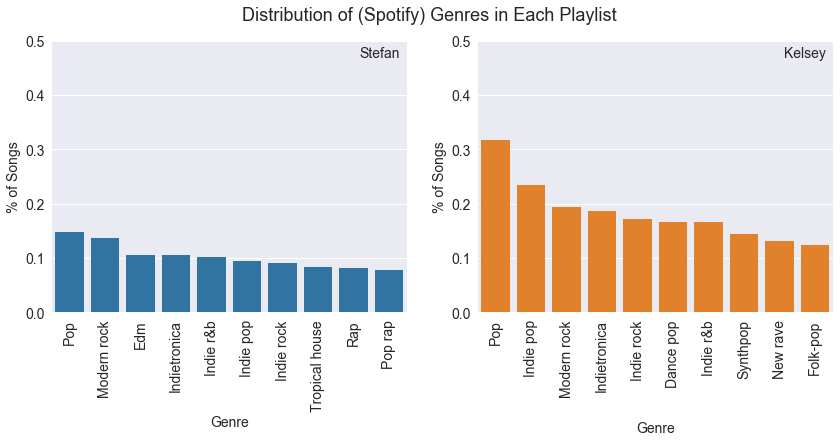

In [589]:
# Plot genres
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='Genre', y='% of Songs', data=stefan_top_tags_df, color=sns.color_palette()[0])
ax1.set_ylabel('% of Songs', fontsize=14)
ax1.set_xlabel('Genre', fontsize=14)
ax1.set_ylim(0,0.5)
ax1.annotate('Stefan', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='Genre', y='% of Songs', data=kelsey_top_tags_df, color=sns.color_palette()[1])
ax2.set_ylabel('% of Songs', fontsize=14)
ax2.set_xlabel('Genre', fontsize=14, labelpad=24)
ax2.set_ylim(0,0.5)
ax2.annotate('Kelsey', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.suptitle("Distribution of (Spotify) Genres in Each Playlist", fontsize=18, y=0.975)
plt.savefig('svsk_spotify_genres.png', dpi=200, format='png', bbox_inches='tight')

In [352]:
# number of genres in my and Kelsey playlists
len(stefan_genres), len(kelsey_genres)

(358, 161)

In [323]:
# Make a list of all unique genres
genres = []
for genre, value in stefan_genres.items():
    genres.append(genre)

for genre, value in kelsey_genres.items():
    if genre not in genres:
        genres.append(genre)

In [336]:
# Calculate differences between genres in both lists
list_sg = set(stefan_genres)
list_kg = set(kelsey_genres)

genre_diff = []
for genre in genres:
    if genre in list_sg and genre in list_kg:
        genre_diff.append([genre, stefan_genres[genre]-kelsey_genres[genre]])
    elif genre in list_sg and genre not in list_kg:
        genre_diff.append([genre, stefan_genres[genre]])
    else:
        genre_diff.append([genre, -kelsey_genres[genre]])

In [337]:
# sort
genre_diff_sorted = sorted(genre_diff, key=lambda x: abs(x[1]), reverse=True)

In [343]:
# place genre differences into pandas dataframe
genre_diff_df = pd.DataFrame(genre_diff_sorted, columns=['Genre', 'Absolute Percent Difference'])
genre_diff_df['user'] = 'Kelsey'
genre_diff_df.loc[genre_diff_df['Absolute Percent Difference'] > 1, 'user'] = 'Stefan'
genre_diff_df['Absolute Percent Difference'] = abs(genre_diff_df['Absolute Percent Difference'])

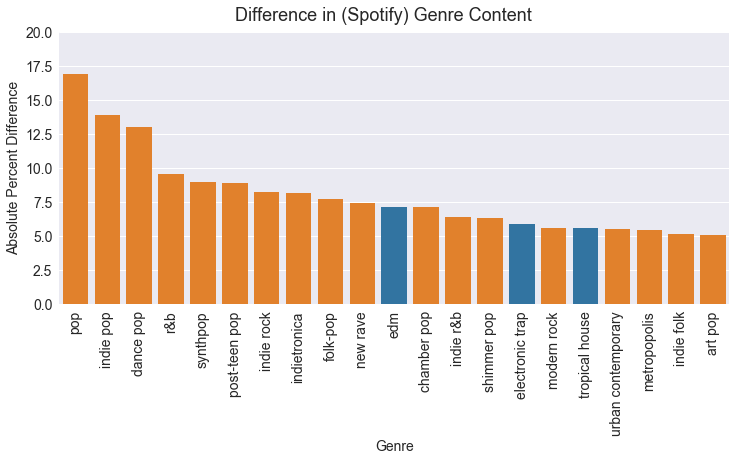

In [588]:
# plot genre differences
sns.set()
sns.set_palette("tab10")
sc = ['C0']
kc = ['C1']
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x='Genre', y='Absolute Percent Difference', data=genre_diff_df.loc[0:20], palette=10*kc+sc+3*kc+sc+kc+sc+4*kc)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Absolute Percent Difference', fontsize=14)
ax.set_ylim(0,20)

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.suptitle("Difference in (Spotify) Genre Content", fontsize=18, y=0.95)
plt.savefig('svsk_genre_diffs_spotify.png', dpi=200, format='png', bbox_inches='tight')

Now we do the same genre analysis but for the genres scraped from LastFM.

In [40]:
# Count each genre and put top genres into a list
stefan_top_tags = []
temp = Counter(stefan_playlist_df['lastfm_genre'])
for item in temp.most_common(10):
    tag_data = {}
    tag = item[0]
    pct = item[1] / sum(temp.values())
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    stefan_top_tags.append(tag_data)
    
kelsey_top_tags = []
temp = Counter(kelsey_playlist_df['lastfm_genre'])
for item in temp.most_common(10):
    tag_data = {}
    tag = item[0]
    pct = item[1] / sum(temp.values())
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    kelsey_top_tags.append(tag_data)
    
stefan_top_tags_df = pd.DataFrame(stefan_top_tags)
kelsey_top_tags_df = pd.DataFrame(kelsey_top_tags)

In [41]:
len(Counter(stefan_playlist_df['lastfm_genre'])), len(Counter(kelsey_playlist_df['lastfm_genre']))

(106, 34)

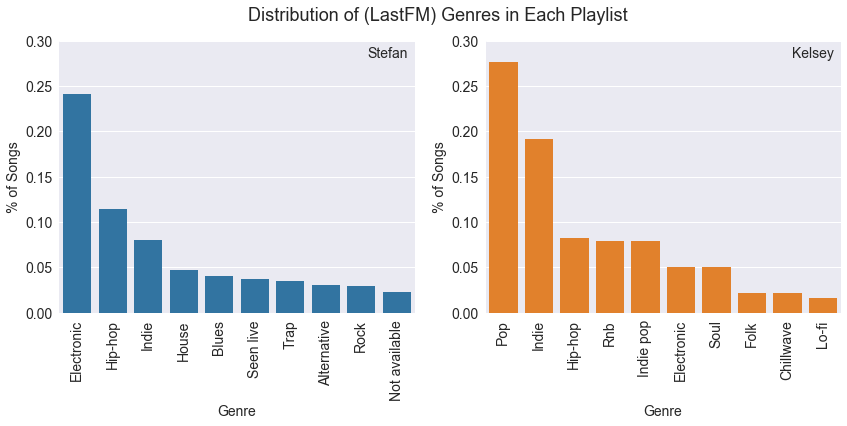

In [592]:
# Plot genres
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='Genre', y='% of Songs', data=stefan_top_tags_df, color=sns.color_palette()[0])
ax1.set_ylabel('% of Songs', fontsize=14)
ax1.set_xlabel('Genre', fontsize=14)
ax1.set_ylim(0,0.3)
ax1.annotate('Stefan', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='Genre', y='% of Songs', data=kelsey_top_tags_df, color=sns.color_palette()[1])
ax2.set_ylabel('% of Songs', fontsize=14)
ax2.set_xlabel('Genre', fontsize=14, labelpad=24)
ax2.set_ylim(0,0.3)
ax2.annotate('Kelsey', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.suptitle("Distribution of (LastFM) Genres in Each Playlist", fontsize=18, y=0.975)
plt.savefig('svsk_lastfm_genres.png', dpi=200, format='png', bbox_inches='tight')

In [682]:
stefan_top_tags_df = pd.DataFrame(stefan_top_tags)
stefan_top_tags_df.set_index(keys='Genre', inplace=True)
kelsey_top_tags_df = pd.DataFrame(kelsey_top_tags)
kelsey_top_tags_df.set_index(keys='Genre', inplace=True)

In [699]:
merged_tags = stefan_top_tags_df.merge(kelsey_top_tags_df, how='outer', left_index=True, right_index=True)
merged_tags.fillna(0, inplace=True)
merged_tags.rename(columns={'% of Songs_x': 'Stefan','% of Songs_y': 'Kelsey'}, inplace=True)

In [711]:
def calc_genre_inc(row):
    if row['Stefan'] > row['Kelsey'] and row['Stefan'] != 0 and row['Kelsey'] != 0:
        return row['Stefan'] / row['Kelsey']
    elif row['Kelsey'] > row['Stefan'] and row['Stefan'] != 0 and row['Kelsey'] != 0:
        return row['Kelsey'] / row['Stefan']

In [726]:
mult = merged_tags.apply(calc_genre_inc, axis=1)
mult.fillna(0, inplace=True)
mult.sort_values(ascending=False)[0:5]

Genre
Pop                  14.041463
Indie pop             8.975367
Rnb                   7.180294
Electronic            4.787409
Singer-songwriter     4.308176
dtype: float64

# Logistic regression

Here we try to predict whether a song belongs to Kelsey or my playlist based on the extracted audio features.

In [58]:
# Put Spotify genres into a list
stefan_genres = genre_counter(stefan_playlist_df)
kelsey_genres = genre_counter(kelsey_playlist_df)

In [59]:
# make a list of all unique genres
genres = []
for genre, value in stefan_genres.items():
    genres.append(genre)

for genre, value in kelsey_genres.items():
    if genre not in genres:
        genres.append(genre)

In [60]:
stefan_playlist_df, stefan_means_and_stds_df = load_data('stefan_music.csv')
kelsey_playlist_df, kelsey_means_and_stds_df = load_data('kelsey_music.csv')

# Add user data to each dataframe
stefan_playlist_df['user'] = 0
kelsey_playlist_df['user'] = 1

# Sample Stefan's playlist dataframe and select # of songs equal to # of songs in Kelsey's playlist
stefan_playlist_df = stefan_playlist_df.sample(n=len(kelsey_playlist_df), random_state=42)

# Combine dataframes
data = pd.concat([stefan_playlist_df, kelsey_playlist_df])
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

# Create new columns in combined dataframe for each genre. For each observation, a value of 1 is placed
# in the genre column if the song is labeled as that genre.
for genre in genres:
    data[genre] = 0
    
for index in range(len(data)):
    for genre in literal_eval(data.loc[index, 'artist_genre']):
        data.loc[index, genre] = 1

In [61]:
# Select features on which to fit logistic regression model
features = np.array(data.columns)
features = np.delete(features, [1, 2, 7, 8, 10, 11, 13, 16, 18, 19])

# Normalize features for logistic regression. Normalization values are chosen close to maximum values.
X = data[features]
X['duration'] = X['duration'] / 700
X['loudness'] = X['loudness'] / -60
X['tempo'] = X['tempo'] / 200
y = data['user']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [62]:
# Test logistic regression using various regularization parameters
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
for value in C:
    score = []
    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random.randint(0,100000))
        X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random.randint(0,100000))
        clf = LogisticRegression(C=value, max_iter=10000, random_state=random.randint(0,100000))
        clf.fit(X_train, y_train)
        score.append(clf.score(X_cv, y_cv))
    print(np.mean(score))

0.674566929134
0.715354330709
0.753464566929
0.763779527559
0.754566929134
0.753622047244
0.748188976378
0.744960629921
0.747952755906


In [63]:
# Test logistic regression model on test set.
score = []
f1score = []
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random.randint(0,100000))
    X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random.randint(0,100000))
    clf = LogisticRegression(C=10, max_iter=1000000, random_state=random.randint(0,100000))
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
    f1score.append(f1_score(y_test, clf.predict(X_test)))

'The logistic regression classifier predicts the correct playlist {:.2}/10 times'.format(np.mean(score)*10)

'The logistic regression classifier predicts the correct playlist 7.6/10 times'

In [64]:
# calculate the f1 score
'The F1 score on this model is {:.2f}'.format(np.mean(f1score))

'The F1 score on this model is 0.75'

In [65]:
# calculate fraction of predictions that have low probability of being accurate (less than 0.7)
tf_array = clf.predict_proba(X_test) > 0.7
ff_indices = []
tf_indices = []
for index in range(len(X_test)):
    if not tf_array[index][0] and not tf_array[index][1]:
        ff_indices.append(index)
    else:
        tf_indices.append(index)
len(ff_indices) / len(tf_array)

0.21875

In [66]:
# Of the predictions with high probability of being accurate, what fraction of those actually give the right answer?
clf.score(X_test.iloc[tf_indices], y_test.iloc[tf_indices])

0.85999999999999999

In [500]:
# print out the top predictors of the logistic regression
stefan_predictors = []
kelsey_predictors = []
for index in range(len(clf.coef_[0])):
    if clf.coef_[0][index] < 0:
        stefan_predictors.append([X_train.columns[index], clf.coef_[0][index]])
    else:
        kelsey_predictors.append([X_train.columns[index], clf.coef_[0][index]])

stefan_predictors.sort(key=lambda x: abs(x[1]), reverse=True)
kelsey_predictors.sort(key=lambda x: abs(x[1]), reverse=True)

print("Stefan's Top Predictors:\n_________________________")
for index in range(15):
    print(stefan_predictors[index][0].capitalize() + ', ' + '{:.2f}'.format(stefan_predictors[index][1]))
print('\n')
print("Kelsey's Top Predictors:\n_________________________")
for index in range(15):
    print(kelsey_predictors[index][0].capitalize() + ', ' + '{:.2f}'.format(kelsey_predictors[index][1]))

Stefan's Top Predictors:
_________________________
Portland indie, -3.66
Slow core, -3.17
Indietronica, -3.15
Math pop, -2.66
Speechiness, -2.64
Downtempo, -2.58
Southern hip hop, -2.39
Ninja, -2.35
Dwn trap, -2.25
Alternative rock, -2.23
Electronic trap, -2.18
Alternative dance, -2.15
Stomp and holler, -2.12
Dirty south rap, -2.08
Big room, -2.08


Kelsey's Top Predictors:
_________________________
New rave, 4.26
Bay area indie, 3.25
Pop quebecois, 3.17
Indie rock, 2.87
Soul, 2.78
Preverb, 2.72
Vegas indie, 2.56
Twee pop, 2.51
Seattle indie, 2.51
Urban contemporary, 2.41
Malaysian pop, 2.27
Neo soul, 2.25
Hip hop, 2.16
Canadian folk, 2.06
Detroit hip hop, 2.04


Most of the top predictors are genres, so how well does a classifier do with just genre information?

In [475]:
# Copy training data and select only genre columns
X_train_genre = X_train.copy()
X_test_genre = X_test.copy()

features = np.array(X_train_genre.columns)
features = np.delete(features, np.arange(10))

X_train_genre = X_train_genre[features]
X_test_genre = X_test_genre[features]

# Rerun logistic regression
clf = LogisticRegression(C=10, max_iter=1000000, random_state=21)
score = []
for _ in range(0,1000):
    clf.fit(X_train_genre, y_train)
    score.append(clf.score(X_test_genre, y_test))
np.mean(score)

0.7578125

# Finding music that both users may like

In [67]:
# Find indicies of songs where the logistic regression prediction probability is between 40-60%
# We will train our model, select the songs with prediction probability between 40-60%, and repeat this process
# several times and select the most commonly predicted songs.

similar_music_index = []
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random.randint(0,100000))
    clf = LogisticRegression(C=10, max_iter=1000000, random_state=random.randint(0,100000))
    clf.fit(X_train, y_train)
    
    probs = clf.predict_proba(X)
    for index in range(len(probs)):
        if abs(probs[index][1] - probs[index][0]) < 0.2:
            similar_music_index.append(X.index[index])

In [68]:
similar_music_index_count = Counter(similar_music_index)

# Find names of songs
similar_music_names = []
for song in similar_music_index_count.most_common(21):
    if data.loc[song[0], 'user'] == 0:
        name = 'Stefan'
    else:
        name = 'Kelsey'
    similar_music_names.append([data.loc[song[0], 'name'], literal_eval(data.loc[song[0], 'artists'])[0], name])

similar_music_names

[['DonaldTrumpMakesMeWannaSmokeCrack - Petals Remix', 'Ledinsky', 'Stefan'],
 ['I Stand Alone', 'Theophilus London', 'Kelsey'],
 ['Uptown Funk', 'Mark Ronson', 'Stefan'],
 ['Movie Loves A Screen', 'April Smith and the Great Picture Show', 'Kelsey'],
 ['This Land Is Your Land', 'Chicano Batman', 'Stefan'],
 ['Weekend - Jai Wolf Remix', 'Mocki', 'Stefan'],
 ['Memory Taffeta', 'Palmistry', 'Stefan'],
 ['Love is Won', 'Lia Ices', 'Kelsey'],
 ['Louie Louie', 'The Kingsmen', 'Stefan'],
 ['Felicity', "Leat'eq", 'Stefan'],
 ['Symphonies', 'Dan Black', 'Kelsey'],
 ['Daphne', 'Lia Ices', 'Kelsey'],
 ['Colder', 'Young Gunna', 'Stefan'],
 ['Last Love', 'RIVRS', 'Kelsey'],
 ['Weeds Or Wildflowers', 'Parsonsfield', 'Stefan'],
 ['Little Marriage', 'Lia Ices', 'Kelsey'],
 ['Trouble So Hard', 'Vera Hall', 'Stefan'],
 ['With You', 'Drake', 'Kelsey'],
 ['Safari Song', 'Greta Van Fleet', 'Stefan'],
 ['Blem', 'Drake', 'Kelsey'],
 ['Breezeblocks', 'alt-J', 'Kelsey']]

# EVERYTHING BELOW THIS WAS NOT USED IN THE WRITE-UP

# Genre-specific distributions in audio features

The global distributions for audio features are very similar between Kelsey and my playlists, but what about the distributions within a single genre? Here we calculate the distributions for the electronic and indie genres.

In [511]:
# Assign user column to each playlist. 0 indicates user is kelsey and 1 indicates user is stefan
stefan_playlist_df['user'] = 0
kelsey_playlist_df['user'] = 1

# Combine dataframes
data = pd.concat([stefan_playlist_df, kelsey_playlist_df])
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

# Create new columns in combined dataframe for each genre. For each observation, a value of 1 is placed
# in the genre column if the song is labeled as that genre.
for genre in data['lastfm_genre'].unique():
    data[genre] = 0
    
for index in range(len(data)):
    genre = data.loc[index, 'lastfm_genre']
    data.loc[index, genre] = 1

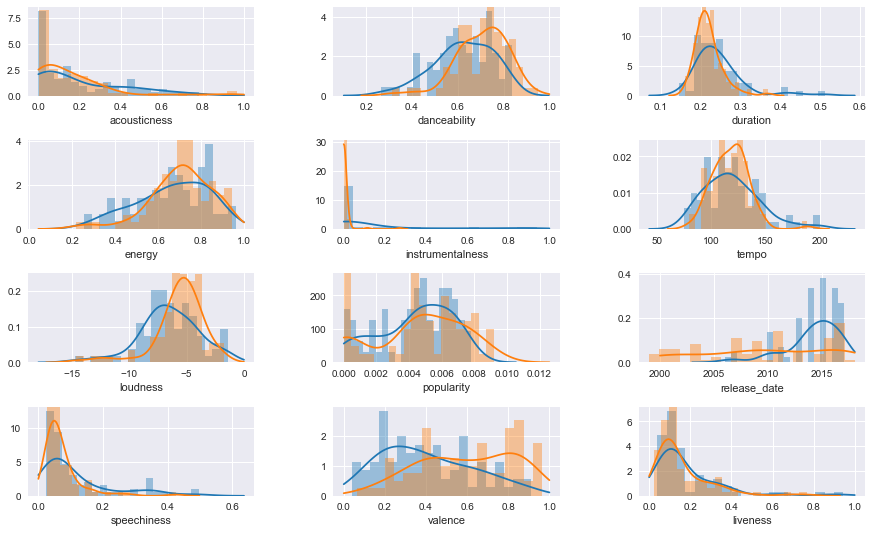

In [512]:
# Select electronic genre
stefan_playlist_electronic = data[(data['electronic'] == 1) & (data['user'] == 0)]
kelsey_playlist_pop = data[(data['pop'] == 1) & (data['user'] == 1)]


# Plot distributions of audio features
sns.set()
sns.set_palette("tab10")
fig, axs = plt.subplots(4,3, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.35)
axs = axs.ravel()

bins=20
for i in range(len(axs)):
    if relevant_features[i] == 'release_date':
        clip_range = (2000,2018)
    elif relevant_features[i] == 'duration':
        clip_range = (0,500000)
    elif relevant_features[i] == 'tempo':
        clip_range = (0,300)
    elif relevant_features[i] == 'loudness':
        clip_range = (-60,0)
    elif relevant_features[i] == 'popularity':
        clip_range = (0,100)
    else: 
        clip_range = (0,1)
    sns.distplot(stefan_playlist_electronic[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C0', fit_kws={"color": 'C0'}, kde_kws={'clip': clip_range})
    sns.distplot(kelsey_playlist_pop[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C1', fit_kws={"color": 'C1'}, kde_kws={'clip': clip_range})

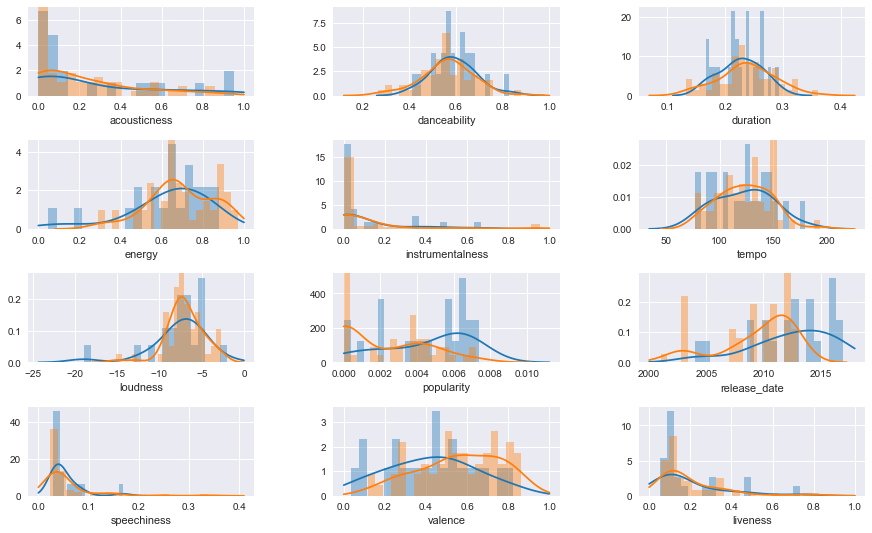

In [513]:
# Select indie genre
stefan_playlist_indie = data[(data['indie'] == 1) & (data['user'] == 0)]
kelsey_playlist_indie = data[(data['indie'] == 1) & (data['user'] == 1)]

# Plot audio features
sns.set()
sns.set_palette("tab10")
fig, axs = plt.subplots(4,3, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.35)
axs = axs.ravel()

bins=20
for i in range(len(axs)):
    if relevant_features[i] == 'release_date':
        clip_range = (2000,2018)
    elif relevant_features[i] == 'duration':
        clip_range = (0,500000)
    elif relevant_features[i] == 'tempo':
        clip_range = (0,300)
    elif relevant_features[i] == 'loudness':
        clip_range = (-60,0)
    elif relevant_features[i] == 'popularity':
        clip_range = (0,100)
    else: 
        clip_range = (0,1)
    sns.distplot(stefan_playlist_indie[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C0', fit_kws={"color": 'C0'}, kde_kws={'clip': clip_range})
    sns.distplot(kelsey_playlist_indie[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C1', fit_kws={"color": 'C1'}, kde_kws={'clip': clip_range})
plt.savefig('svsk_distributions_indie.png', dpi=200, format='png')

# Top tracks of 2017

In [11]:
top2017_data = analyze_playlist('spotify:user:spotify:playlist:37i9dQZF1DX7Axsg3uaDZb')
top2017_df = pd.DataFrame(top2017_data)
top2017_df.to_csv('top2017.csv')

NameError: name 'sp' is not defined

In [12]:
top2017_df, top2017_means_and_stds_df = load_data('top2017.csv')

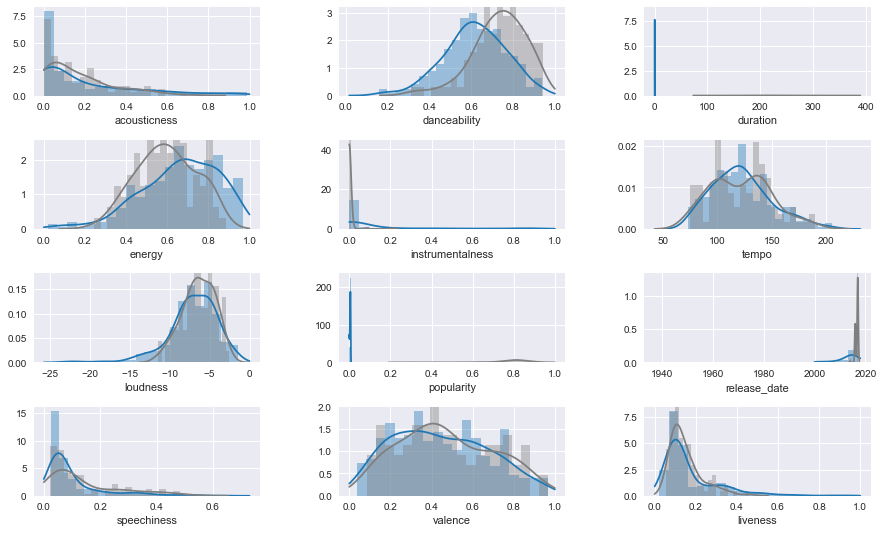

In [505]:
# Select relevant features
relevant_features = (['acousticness', 'danceability', 'duration', 
                      'energy', 'instrumentalness', 'tempo',
                     'loudness', 'popularity', 'release_date',
                     'speechiness', 'valence', 'liveness'])

# Plot audio features distributions for both Kelsey and myself
top2017_df, top2017_means_and_stds_df = load_data('top2017.csv')

sns.set()
sns.set_palette("tab10", n_colors=10)
fig, axs = plt.subplots(4,3, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.35)
axs = axs.ravel()

bins=20
for i in range(len(axs)):
    if relevant_features[i] == 'release_date':
        clip_range = (2000,2018)
    elif relevant_features[i] == 'duration':
        clip_range = (0,500000)
    elif relevant_features[i] == 'tempo':
        clip_range = (0,300)
    elif relevant_features[i] == 'loudness':
        clip_range = (-60,0)
    elif relevant_features[i] == 'popularity':
        clip_range = (0,1)
    else: 
        clip_range = (0,1)
    sns.distplot(stefan_playlist_df[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C0', fit_kws={"color": 'C0'}, kde_kws={'clip': clip_range})
    sns.distplot(top2017_df[relevant_features[i]], bins=bins, kde=True, rug=False, ax=axs[i], color='C7', fit_kws={"color": 'C1'}, kde_kws={'clip': clip_range})
plt.savefig('svstop2017_distributions.png', dpi=200, format='png')

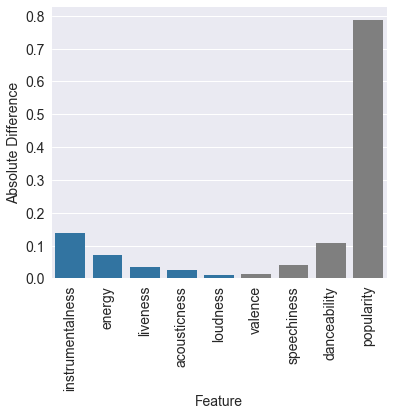

In [506]:
# Calculate differences between means and store in a pandas dataframe
audio_features = normalize_features(stefan_means_and_stds_df, 'Stefan')
audio_features = audio_features.append(normalize_features(top2017_means_and_stds_df, 'Top 2017'), ignore_index=True)

audio_features_mi = audio_features.set_index(['feature', 'name'])
difference = pd.DataFrame(columns=['Feature', 'Difference', 'bigger'])
for feature in audio_features['feature'].unique():
    value = audio_features_mi.loc[(feature, 'Stefan'), 'mean'] - audio_features_mi.loc[(feature, 'Top 2017'), 'mean']
    if value > 0:
        bigger = 'Stefan'
    else:
        bigger = 'Top 2017'
    difference = difference.append({'Feature': feature, 'Difference': value, 'bigger': bigger}, ignore_index=True)

difference.sort_values('Difference', ascending=False, inplace=True)
difference['Absolute Difference'] = abs(difference['Difference'])

# Plot differences between means and color code each feature according to who has a larger mean.
sns.set()
sns.set_palette("tab10", n_colors=10)
sc = ['C0']
kc = ['C7']
fig = plt.figure(figsize=(6,5))
ax = sns.barplot(x='Feature', y='Absolute Difference', data=difference, palette= sc*5 + kc*4)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Absolute Difference', fontsize=14)


plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.savefig('svstop2017_means_diff.png', dpi=200, format='png', bbox_inches='tight')

Now we compare Spotify genre distribution

In [507]:
top2017_genres = genre_counter(top2017_df)
top2017_top_tags = []
temp = sorted(top2017_genres.items(), key=operator.itemgetter(1), reverse=True)[0:10]
for item in temp:
    tag_data = {}
    tag = item[0]
    pct = item[1] / 100
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    top2017_top_tags.append(tag_data)

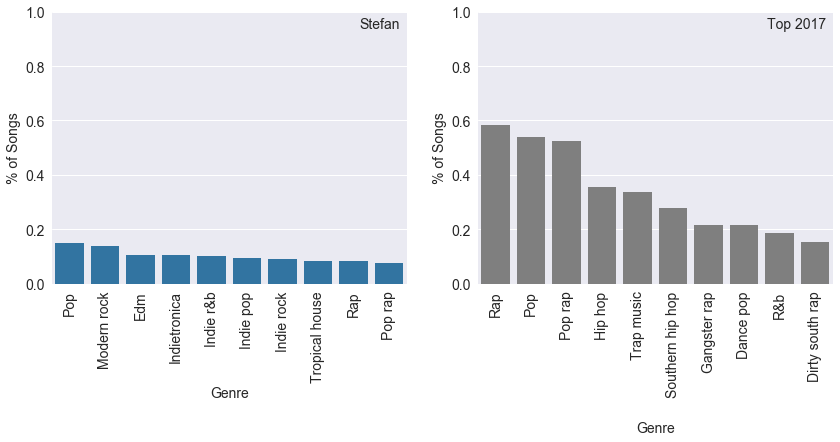

In [508]:
top2017_top_tags_df = pd.DataFrame(top2017_top_tags)

sns.set()
sns.set_palette("tab10", n_colors=10)
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='Genre', y='% of Songs', data=stefan_top_tags_df, color='C0')
ax1.set_ylabel('% of Songs', fontsize=14)
ax1.set_xlabel('Genre', fontsize=14)
ax1.set_ylim(0,1)
ax1.annotate('Stefan', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='Genre', y='% of Songs', data=top2017_top_tags_df, color='C7')
ax2.set_ylabel('% of Songs', fontsize=14)
ax2.set_xlabel('Genre', fontsize=14, labelpad=24)
ax2.set_ylim(0,1)
ax2.annotate('Top 2017', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.savefig('svstop2017_spotify_genre.png', dpi=200, format='png')

And now lastfm genres

In [509]:
stefan_top_tags = []
temp = Counter(stefan_playlist_df['lastfm_genre'])
for item in temp.most_common(10):
    tag_data = {}
    tag = item[0]
    pct = item[1] / sum(temp.values())
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    stefan_top_tags.append(tag_data)
    
top2017_top_tags = []
temp = Counter(top2017_df['lastfm_genre'])
for item in temp.most_common(10):
    tag_data = {}
    tag = item[0]
    pct = item[1] / sum(temp.values())
    tag_data['Genre'] = tag.capitalize()
    tag_data['% of Songs'] = pct
    top2017_top_tags.append(tag_data)

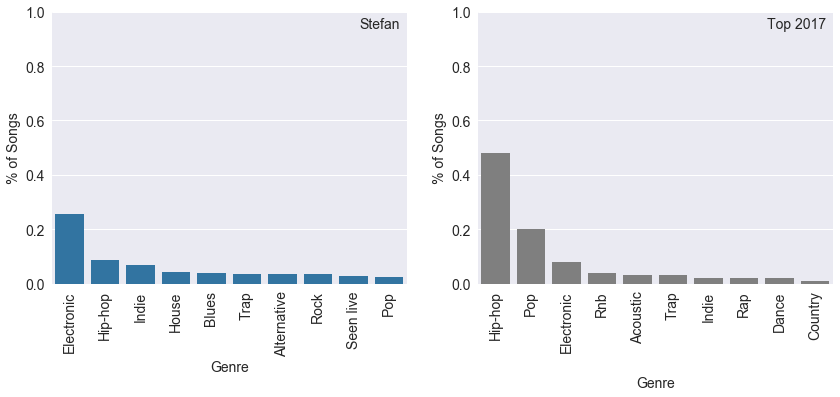

In [510]:
stefan_top_tags_df = pd.DataFrame(stefan_top_tags)
top2017_top_tags_df = pd.DataFrame(top2017_top_tags)

sns.set()
sns.set_palette("tab10", n_colors=10)
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='Genre', y='% of Songs', data=stefan_top_tags_df, color='C0')
ax1.set_ylabel('% of Songs', fontsize=14)
ax1.set_xlabel('Genre', fontsize=14)
ax1.set_ylim(0,1)
ax1.annotate('Stefan', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='Genre', y='% of Songs', data=top2017_top_tags_df, color='C7')
ax2.set_ylabel('% of Songs', fontsize=14)
ax2.set_xlabel('Genre', fontsize=14, labelpad=24)
ax2.set_ylim(0,1)
ax2.annotate('Top 2017', 
                    xy = (1,1),
                    xytext=(0.98, 0.98),
                    xycoords='axes fraction',
                    textcoords='axes fraction',
                    horizontalalignment='right',
                    verticalalignment='top',
                    fontsize='14')
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);

plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    ax.tick_params(labelsize=14)
plt.savefig('svstop2017_lastfm_genre.png', dpi=200, format='png')

#  Neural network on S/K music

Fit a neural network to the training data. TLDR: it's not better than logistic regression

In [2]:
stefan_playlist_df = pd.read_csv('stefan_music.csv', index_col = 0)
kelsey_playlist_df = pd.read_csv('kelsey_music.csv', index_col = 0)

stefan_playlist_df['user'] = 0
kelsey_playlist_df['user'] = 1
stefan_playlist_df = stefan_playlist_df.sample(n=len(kelsey_playlist_df))
data = pd.concat([stefan_playlist_df, kelsey_playlist_df])
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

for genre in data['lastfm_genre'].unique():
    data[genre] = 0
    
for index in range(len(data)):
    genre = data.loc[index, 'lastfm_genre']
    data.loc[index, genre] = 1

In [3]:
features = np.array(data.columns)
features = np.delete(features, [1, 2, 7, 8, 10, 11, 13, 16, 18, 19])

X = data[features]
X['popularity'] = X['popularity'] / 100
X['duration'] = X['duration'] / 500000
X['loudness'] = X['loudness'] / -60
X['tempo'] = X['tempo'] / 200
y = data['user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [19]:
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', max_iter=1000, random_state=12).fit(X_train, y_train)

In [24]:
clf.score(X_test, y_test)

0.82198952879581155

In [ ]:
stefan_playlist_df['user'] = 0
kelsey_playlist_df['user'] = 1

data = pd.concat([stefan_playlist_df, kelsey_playlist_df])
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

for genre in data['lastfm_genre'].unique():
    data[genre] = 0
    
for index in range(len(data)):
    genre = data.loc[index, 'lastfm_genre']
    data.loc[index, genre] = 1

#  Visualizing data in 2D

In [273]:
relevant_features = (['acousticness', 'danceability', 'duration', 
                      'energy', 'instrumentalness', 'tempo',
                     'loudness', 'popularity', 'release_date',
                     'speechiness', 'valence', 'liveness', 'artist_genre'])

stefan_playlist_df, stefan_means_and_stds_df = load_data('stefan_music.csv')
stefan_playlist_df = stefan_playlist_df.loc[:, relevant_features]

kelsey_playlist_df, kelsey_means_and_stds_df = load_data('kelsey_music.csv')
kelsey_playlist_df = kelsey_playlist_df.loc[:, relevant_features]

In [258]:
genres = []
for genre, value in stefan_genres.items():
    genres.append(genre)

for genre, value in kelsey_genres.items():
    if genre[0] not in genres:
        genres.append(genre)

In [274]:
# Add user data to each dataframe
stefan_playlist_df['user'] = 0
kelsey_playlist_df['user'] = 1

# Combine dataframes
data = pd.concat([stefan_playlist_df, kelsey_playlist_df])
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

# Create new columns in combined dataframe for each genre. For each observation, a value of 1 is placed
# in the genre column if the song is labeled as that genre.
for genre in genres:
    data[genre] = 0
    
for index in range(len(data)):
    for genre in literal_eval(data.loc[index, 'artist_genre']):
        data.loc[index, genre] = 1
    
data.drop(labels='artist_genre', axis=1, inplace=True)

In [275]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=2000, init='pca')
tsne_results = tsne.fit_transform(data.loc[:, :].values)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1688 samples in 0.022s...
[t-SNE] Computed neighbors for 1688 samples in 0.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1688
[t-SNE] Computed conditional probabilities for sample 1688 / 1688
[t-SNE] Mean sigma: 2.720123
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.301819
[t-SNE] Error after 2000 iterations: 0.555609


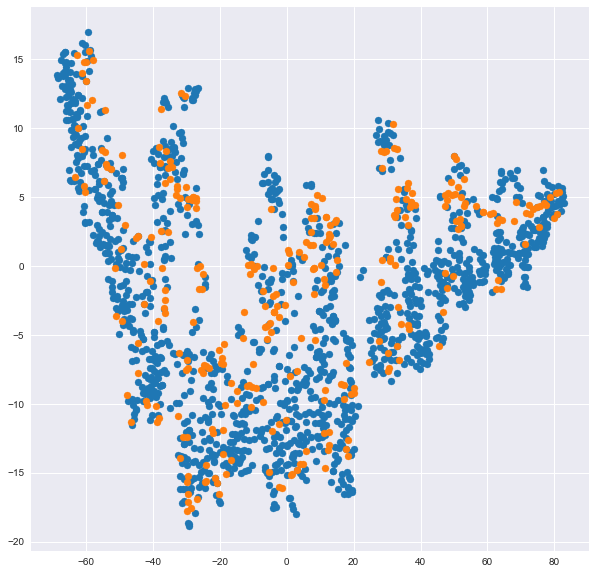

In [276]:
sns.set()
sns.set_palette('tab10', n_colors=10)
x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]
plt.figure(figsize=(10,10))
plt.scatter(x_tsne[:1369], y_tsne[:1369])
plt.scatter(x_tsne[1370:], y_tsne[1370:])

In [277]:
clusters = KMeans(n_clusters=6, random_state=2).fit(tsne_results)

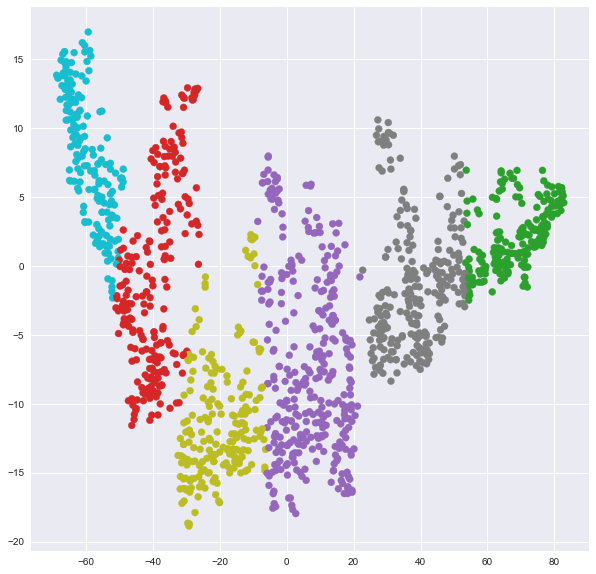

In [278]:
color_dict = {0: 'C2', 1: 'C3', 2: 'C4', 3: 'C7', 4: 'C8', 5: 'C9'}
tsne_colors = [ color_dict[item] for item in clusters.predict(tsne_results)]

x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]
plt.figure(figsize=(10,10))
plt.scatter(x_tsne[:1369], y_tsne[:1369], color=tsne_colors)

In [279]:
cluster_index = clusters.predict(tsne_results)

cluster_lists = []
for cluster in set(cluster_index):
    songs_in_cluster = []
    for index in range(len(cluster_index)):
        if cluster_index[index] == cluster:
            songs_in_cluster.append(index)
    cluster_lists.append(songs_in_cluster)

In [285]:
stefan_playlist_df, stefan_means_and_stds_df = load_data('stefan_music.csv')
kelsey_playlist_df, kelsey_means_and_stds_df = load_data('kelsey_music.csv')
data1 = pd.concat([stefan_playlist_df, kelsey_playlist_df])
data1.loc[cluster_lists[0], :]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


acousticness                                       artist_genre  \
3         0.032200  ['canadian indie', 'chamber pop', 'garage rock...   
3         0.103000       ['dance pop', 'pop', 'post-teen pop', 'r&b']   
22        0.000156  ['alternative dance', 'indie pop', 'indie rock...   
22        0.319000  ['edm', 'electro house', 'house', 'pop', 'prog...   
23        0.000531  ['alternative metal', 'alternative rock', 'blu...   
23        0.177000              ['dance pop', 'pop', 'post-teen pop']   
25        0.000193   ['edm', 'electro house', 'glitch', 'glitch hop']   
25        0.079300                                            ['pop']   
35        0.519000  ['brass band', 'dixieland', 'new orleans blues...   
35        0.226000  ['dance pop', 'indie r&b', 'pop', 'post-teen p...   
43        0.084900  ['bass trap', 'brostep', 'edm', 'electro house...   
43        0.158000  ['boy band', 'latin', 'pop', 'reggaeton', 'tro...   
44        0.337000               ['chamber psych', 'neo-psychedelic']   
44        0.023900  ['dance pop', 'girl group', 'pop', 'post-teen ...   
48        0.032300  ['alternative metal', 'alternative rock', 'blu...   
48        0.197000  ['dance pop', 'pop', 'pop rap', 'post-teen pop...   
51        0.219000  ['dance pop', 'hip hop', 'pop', 'pop rap', 'r&...   
51        0.121000  ['dance pop', 'edm', 'house', 'pop', 'tropical...   
55        0.032700  ['indie pop', 'indie poptimism', 'indietronica...   
55        0.132000  ['canadian hip hop', 'canadian pop', 'hip hop'...   
68        0.223000          ['big beat', 'disco house', 'electronic']   
68        0.052100  ['canadian hip hop', 'canadian pop', 'hip hop'...   
91        0.235000                                        ['pop rap']   
91        0.080800                      ['deep pop r&b', 'indie r&b']   
95        0.016300  ['alternative metal', 'alternative rock', 'blu...   
95        0.027100  ['aussietronica', 'australian dance', 'deep au...   
96        0.033500  ['australian alternative rock', 'australian da...   
96        0.060300  ['art pop', 'chamber pop', 'chillwave', 'dream...   
99        0.005020  ['australian alternative rock', 'australian da...   
99        0.024200                       ['indie pop', 'shimmer pop']   
...            ...                                                ...   
1402           NaN                                                NaN   
1422           NaN                                                NaN   
1424           NaN                                                NaN   
1430           NaN                                                NaN   
1457           NaN                                                NaN   
1468           NaN                                                NaN   
1479           NaN                                                NaN   
1480           NaN                                                NaN   
1494           NaN                                                NaN   
1495           NaN                                                NaN   
1505           NaN                                                NaN   
1515           NaN                                                NaN   
1516           NaN                                                NaN   
1517           NaN                                                NaN   
1519           NaN                                                NaN   
1535           NaN                                                NaN   
1540           NaN                                                NaN   
1542           NaN                                                NaN   
1560           NaN                                                NaN   
1565           NaN                                                NaN   
1567           NaN                                                NaN   
1577           NaN                                                NaN   
1578           NaN                                              

# Stefan top songs

In [ ]:
sp = spotipy.Spotify(auth=token)
results = sp.current_user_top_tracks(time_range='long_term', limit=100)
for i, item in enumerate(results['items']):
            print(i, item['name'], '//', item['artists'][0]['name'])

In [ ]:
song_data = []

for track in results['items']:
    track_info = {}
    track_info['release_date'] = int(track['album']['release_date'].split('-')[0])
    track_info['popularity'] = track['popularity']
    track_info['track_uri'] = track['uri']
    audio_features = get_audio_features(track_info['track_uri'])
    song_data.append({**track_info, **audio_features})

In [ ]:
stefan_top_songs = pd.DataFrame(song_data)
stefan_top_songs.to_csv('stefan_top_songs.csv')

In [ ]:
stefan_top_songs = pd.read_csv('stefan_top_songs.csv', index_col = 0)

In [393]:
relevant_features = (['acousticness', 'danceability', 
                      'energy', 'instrumentalness',
                     'loudness', 'popularity',
                     'speechiness', 'valence', 'liveness'])

def calculate_song_similarity(df, index1, index2):
    similarity = 0
    for feature in relevant_features:
        similarity += 1 - abs(df.loc[index1, feature] - df.loc[index2, feature])
    similarity /= len(relevant_features)
    return similarity

In [394]:
similarities = []
for index in range(len(stefan_playlist_df)):
    similarity = calculate_song_similarity(stefan_playlist_df, index, 1364)
    similarities.append([index, similarity])

In [408]:
for song in sorted(similarities, key= lambda x: x[1], reverse=True)[1:6]:
    song_name = stefan_playlist_df.loc[song[0], 'name']
    artist = literal_eval(stefan_playlist_df.loc[song[0], 'artists'])
    print('Sone name: ' + song_name + ', by: ' + artist[0])

Sone name: Callie (feat. Vic Mensa), by: Donnie Trumpet
Sone name: 10 d E A T h b R E a s T ⚄ ⚄, by: Bon Iver
Sone name: Half Full Glass Of Wine, by: Tame Impala
Sone name: This Song Is Not About a Girl, by: Flume
Sone name: Back On Road, by: Gucci Mane


In [409]:
sorted(similarities, key= lambda x: x[1], reverse=True)[1:6]

[[226, 0.95216866666666655],
 [879, 0.92418888888888917],
 [278, 0.91786666666666683],
 [367, 0.91447777777777772],
 [940, 0.91256666666666653]]

In [412]:
np.dot(stefan_playlist_df.loc[4, relevant_features], stefan_playlist_df.loc[5, relevant_features])

29.760394806000001

In [414]:
stefan_playlist_df.loc[:, 'loudness'] = stefan_playlist_df.loc[:, 'loudness'] / -60
kelsey_playlist_df.loc[:, 'loudness'] = kelsey_playlist_df.loc[:, 'loudness'] / -60

In [423]:
relevant_features = (['acousticness', 'danceability', 
                      'energy', 'instrumentalness',
                     'loudness', 'popularity',
                     'speechiness', 'valence', 'liveness'])

def calculate_song_similarity(df, index1, index2):
    similarity = (np.dot(df.loc[index1, relevant_features], df.loc[index2, relevant_features]) / 
                  (norm(df.loc[index1, relevant_features]) * norm(df.loc[index2, relevant_features])))
    return similarity

In [424]:
similarities = []
for index in range(len(stefan_playlist_df)):
    similarity = calculate_song_similarity(stefan_playlist_df, index, 1364)
    similarities.append([index, similarity])

In [441]:
for song in sorted(similarities, key= lambda x: x[1], reverse=True)[1:10]:
    song_name = stefan_playlist_df.loc[song[0], 'name']
    artist = literal_eval(stefan_playlist_df.loc[song[0], 'artists'])
    print('Sone name: ' + song_name + ', by: ' + artist[0])

Sone name: 10 Bands, by: Drake
Sone name: Callie (feat. Vic Mensa), by: Donnie Trumpet
Sone name: Brave, by: MEMBA
Sone name: Living Single, by: Big Sean
Sone name: Ball And Biscuit, by: The White Stripes
Sone name: Did You See - Mura Masa Remix, by: J Hus
Sone name: Ratchet Commandments, by: Tink
Sone name: Bend, by: Chet Faker
Sone name: Neverland - Memba Remix, by: Mazde


In [439]:
stefan_playlist_df.loc[1364]

acousticness                                       0.148
artist_genre                               ['indie r&b']
artists                                    ['Mura Masa']
danceability                                       0.723
duration                                        0.196547
energy                                             0.697
instrumentalness                                   0.168
key                                                    3
liveness                                          0.0403
loudness                                          0.1195
mode                                                   0
name                                            Lovesick
popularity                                        0.0061
release_date                                        2015
speechiness                                        0.332
tempo                                            177.959
track_uri           spotify:track:0m7TPsBkrZfg6Y6hyuuJLh
valence                        